# Amount of Liscenses Needed as a Percentage of Total Playerbase

## 1) Introduction 

In this project, we are tasked by a computer science research group to analyze data that they have collected. This data is obtained through their minecraft server, in which the player's actions are recorded and stored in datasets, for further analysis. Our key role is to help the research group determine the amount of resources they need to maintain the minecraft server, such as the number of software licenses. Our group chose to answer the second question, which is that: "**We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability**". To answer this question, our group used both the players and sessions datasets to answer the question. 

The players data is a dataset with 9 variables and 196 rows of observations, with the following variables:
- experience (chr): describes the users experience level in minecraft
- subscribe (lgl): whether the user is subscribed or not
- hashedEmail (chr): consists of the user's emails, but hashed into a unique character string
- played_hours (dbl): represent the hours spent playing by the user
- name (chr): represent the name of the user
- gender (chr): represents the gender of the user
- age (dbl): represents the age of the yser
- individualId, organizationName (lgl): blank columns so no data analysis can be performed
  
We used the players data to determine the total number of minecraft players.
Next, the sessions dataset contains 5 variables and 1535 rows of observations, with the variables defined as such:
- hashedEmail (chr): consists of the user's emails, but hashed into a unique character string
- start_time (chr): represent the starting time of the user (when logged in) in a day/month/year time format
- end_time (chr): represent the ending time of the user (when logged out) in a day/month/year time format
- original_start_time (dbl): represents the starting time of the user(when logged in) in UNIX 
- original_end_time (dbl): represents the ending time of the user (when logged out) in UNIX
  
The wrangling needed to clean the datasets has already been completed in our individual planning stages. The sessions dataset takes the main role in our project, in which we use the start and stop times to overall determine the number of licenses to provide.

## 2) Methods and Results

**Data wrangling**

Before any modelling was done, we first need to wrangle and tidy the datasets. We will only use the players dataset to find the total number of players on the server, so no wrangling was needed for that dataset. For the sessions dataset, we eliminated the variables using POSIX time, since they were unnecessary for our analysis, and split the start_time variable into its individual components. The end_time and start_min variables were also eliminated.  In order to predict the hours of the day that have the most amount of players online, we will first determine the number of sessions that are started in each hour of each day.

**Data analysis and model building** 

In order to predict the hours of the day that have the most amount of players online, we will first determine the percentage of players online in a given hour by finding number of sessions within one hour. This was done by grouping the sessions dataset by month, day, and hour in order to find the number of sessions active every hour and divide it with the total number of players. Then, K-NN regression was used for each month to predict the number of licenses needed each month with time as the predictor and the number of platers as the predicted variable. We will split our data 70/30 and tune our model with 1-200 neighbours using 5 fold cross validation. 

### Loading in the libraries

In [1]:
library(tidyverse)
library(repr)
library(rvest)
library(tidymodels)
library(stringr)
library(janitor)
options(repr.matrix.max.rows = 6)
library(cowplot)
set.seed(0)
options(repr.plot.width = 15, repr.plot.height = 15)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────

### Loading in and wrangling the datasets

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
players <- read_csv(players_url)
players
sessions <- read_csv(sessions_url)
sessions

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1   Pro         TRUE    
2   Veteran     TRUE    
3   Veteran    FALSE    
⋮   ⋮          ⋮        
194 Amateur    FALSE    
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
194 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender            age individualId organizationName
1   30.3         Morgan    Male               9  NA           NA              
2    3.8         Christian Male              17  NA           NA              
3    0.0         Blake     Male              17  NA           NA              
⋮   ⋮            ⋮         ⋮                 ⋮   ⋮            ⋮               
194 0.0          Dylan     Prefer not to say 17  NA           NA              
195 2.3          Harlow    Male              17  NA           NA              
196 0.2          Ahmed     Other             91  NA           NA

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail                                                     
1    bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2    36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3    f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮    ⋮                                                               
1533 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1534 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1535 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
     start_time       end_time         original_start_time original_end_time
1    30/06/2024 18:12 30/06/2024 18:24 1.71977e+12         1.71977e+12      
2    17/06/2024 23:33 17/06/2024 23:46 1.71867e+12         1.71867e+12      
3    25/07/2024 17:34 25/07/2024 17:57 1.72193e+12         1.72193e+12      
⋮    ⋮                ⋮                ⋮                   ⋮                
1533 28/07/2024 15:36 28/07/2024 15:57 1.72218e+12         1.72218e+12      
1534 25/07/2024 06:15 25/07/2024 06:22 1.72189e+12         1.72189e+12      
1535 20/05/2024 02:26 20/05/2024 02:45 1.71617e+12         1.71617e+12

In [3]:
sessions_wrangled <- separate(sessions, start_time, 
                              c("start_day", "start_month", "start_year", "start_hour", "start_min"))|>
                    select(start_day,start_month, start_hour) |>
                    mutate(start_day = as.numeric(start_day),
                   start_month = as.numeric(start_month),
                   start_hour = as.numeric(start_hour)) 

sessions_wrangled

start_day start_month start_hour
1    30        6           18        
2    17        6           23        
3    25        7           17        
⋮    ⋮         ⋮           ⋮         
1533 28        7           15        
1534 25        7            6        
1535 20        5            2

### Summary of datasets

In [4]:
total_players <- nrow(players) 
total_players

[1] 196

In [5]:
most_common_hours <- sessions_wrangled |>
                    count(start_hour) |>
                    slice_max(order_by = n, n = 5) 
                    
most_common_hours

start_hour n  
1  2         152
2  4         151
3  3         131
4  0         128
5 23         122

In [6]:
most_common_months <- sessions_wrangled |>
                    count(start_month) |>
                    slice_max(order_by = n, n = 5) 

most_common_months

start_month n  
1 6           447
2 5           344
3 7           288
4 8           221
5 4           143

In [7]:
most_common_days <- sessions_wrangled |>
                    count(start_day) |>
                    slice_max(order_by = n, n = 5) 

most_common_days 

start_day n 
1 28        86
2 25        81
3 17        66
4 27        63
5  1        62

As seen from these summarizations, we have a total of 196 players, and sessions are usually started late at night around May-June at the end of the months.  

As seen from the summary, there are 196 players playing signed up for the study.

### Visualization of datasets

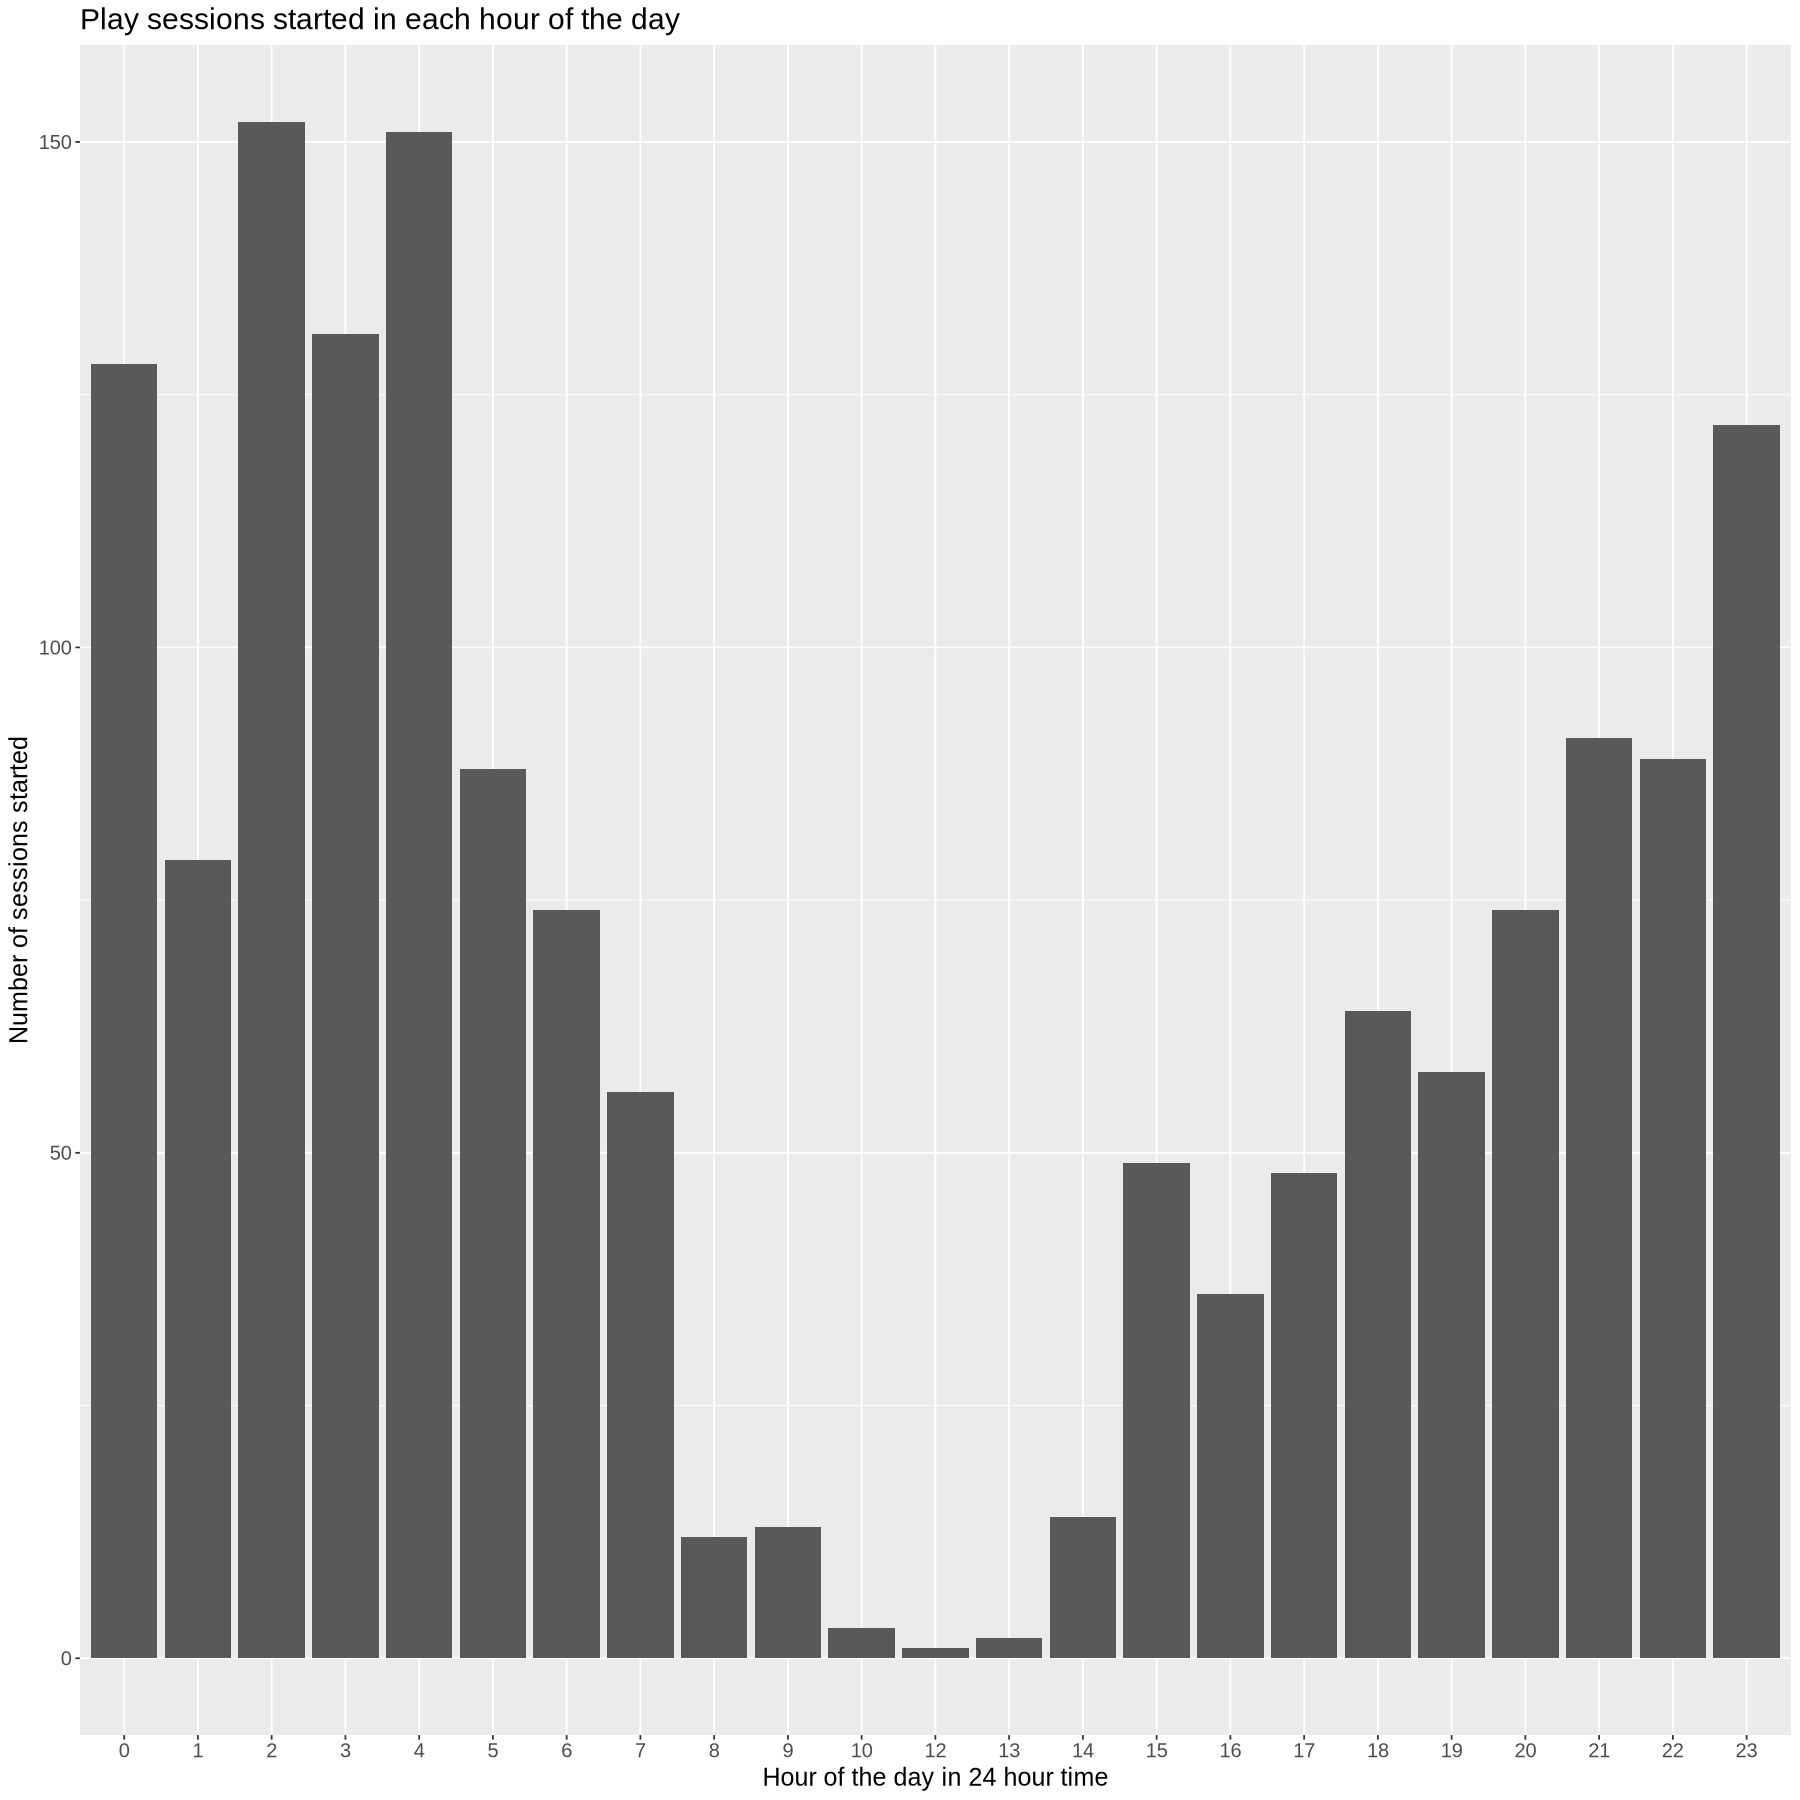

In [8]:
sessions_hours <- mutate(sessions_wrangled, start_hour = as.factor(start_hour)) |>
    ggplot(aes(x = start_hour)) +
    geom_bar() +
    labs(y = "Number of sessions started", x = "Hour of the day in 24 hour time", title = "Play sessions started in each hour of the day") +
    theme(text = element_text(size = 15))
sessions_hours

Fig. 1: This graph shows most sessions start between the evening and early morning. We can expect the largest amount of required liscenses to be around this time range.

### Creating and validating the model

#### Full Year Prediction

In [9]:
sessions_per_hour <- sessions_wrangled |>
    group_by(start_month, start_day, start_hour) |>
    summarize(number_of_sessions = n()) |>
    arrange(-number_of_sessions) |>
    mutate(percentage_of_players = number_of_sessions/total_players*100)
sessions_per_hour

`summarise()` has grouped output by 'start_month', 'start_day'. You can
override using the `.groups` argument.


start_month start_day start_hour number_of_sessions percentage_of_players
1   6           27        22         15                 7.653061             
2   7           25         7         13                 6.632653             
3   7           25         6         11                 5.612245             
⋮   ⋮           ⋮         ⋮          ⋮                  ⋮                    
946 9           21        23         1                  0.5102041            
947 9           24         6         1                  0.5102041            
948 9           26         6         1                  0.5102041

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


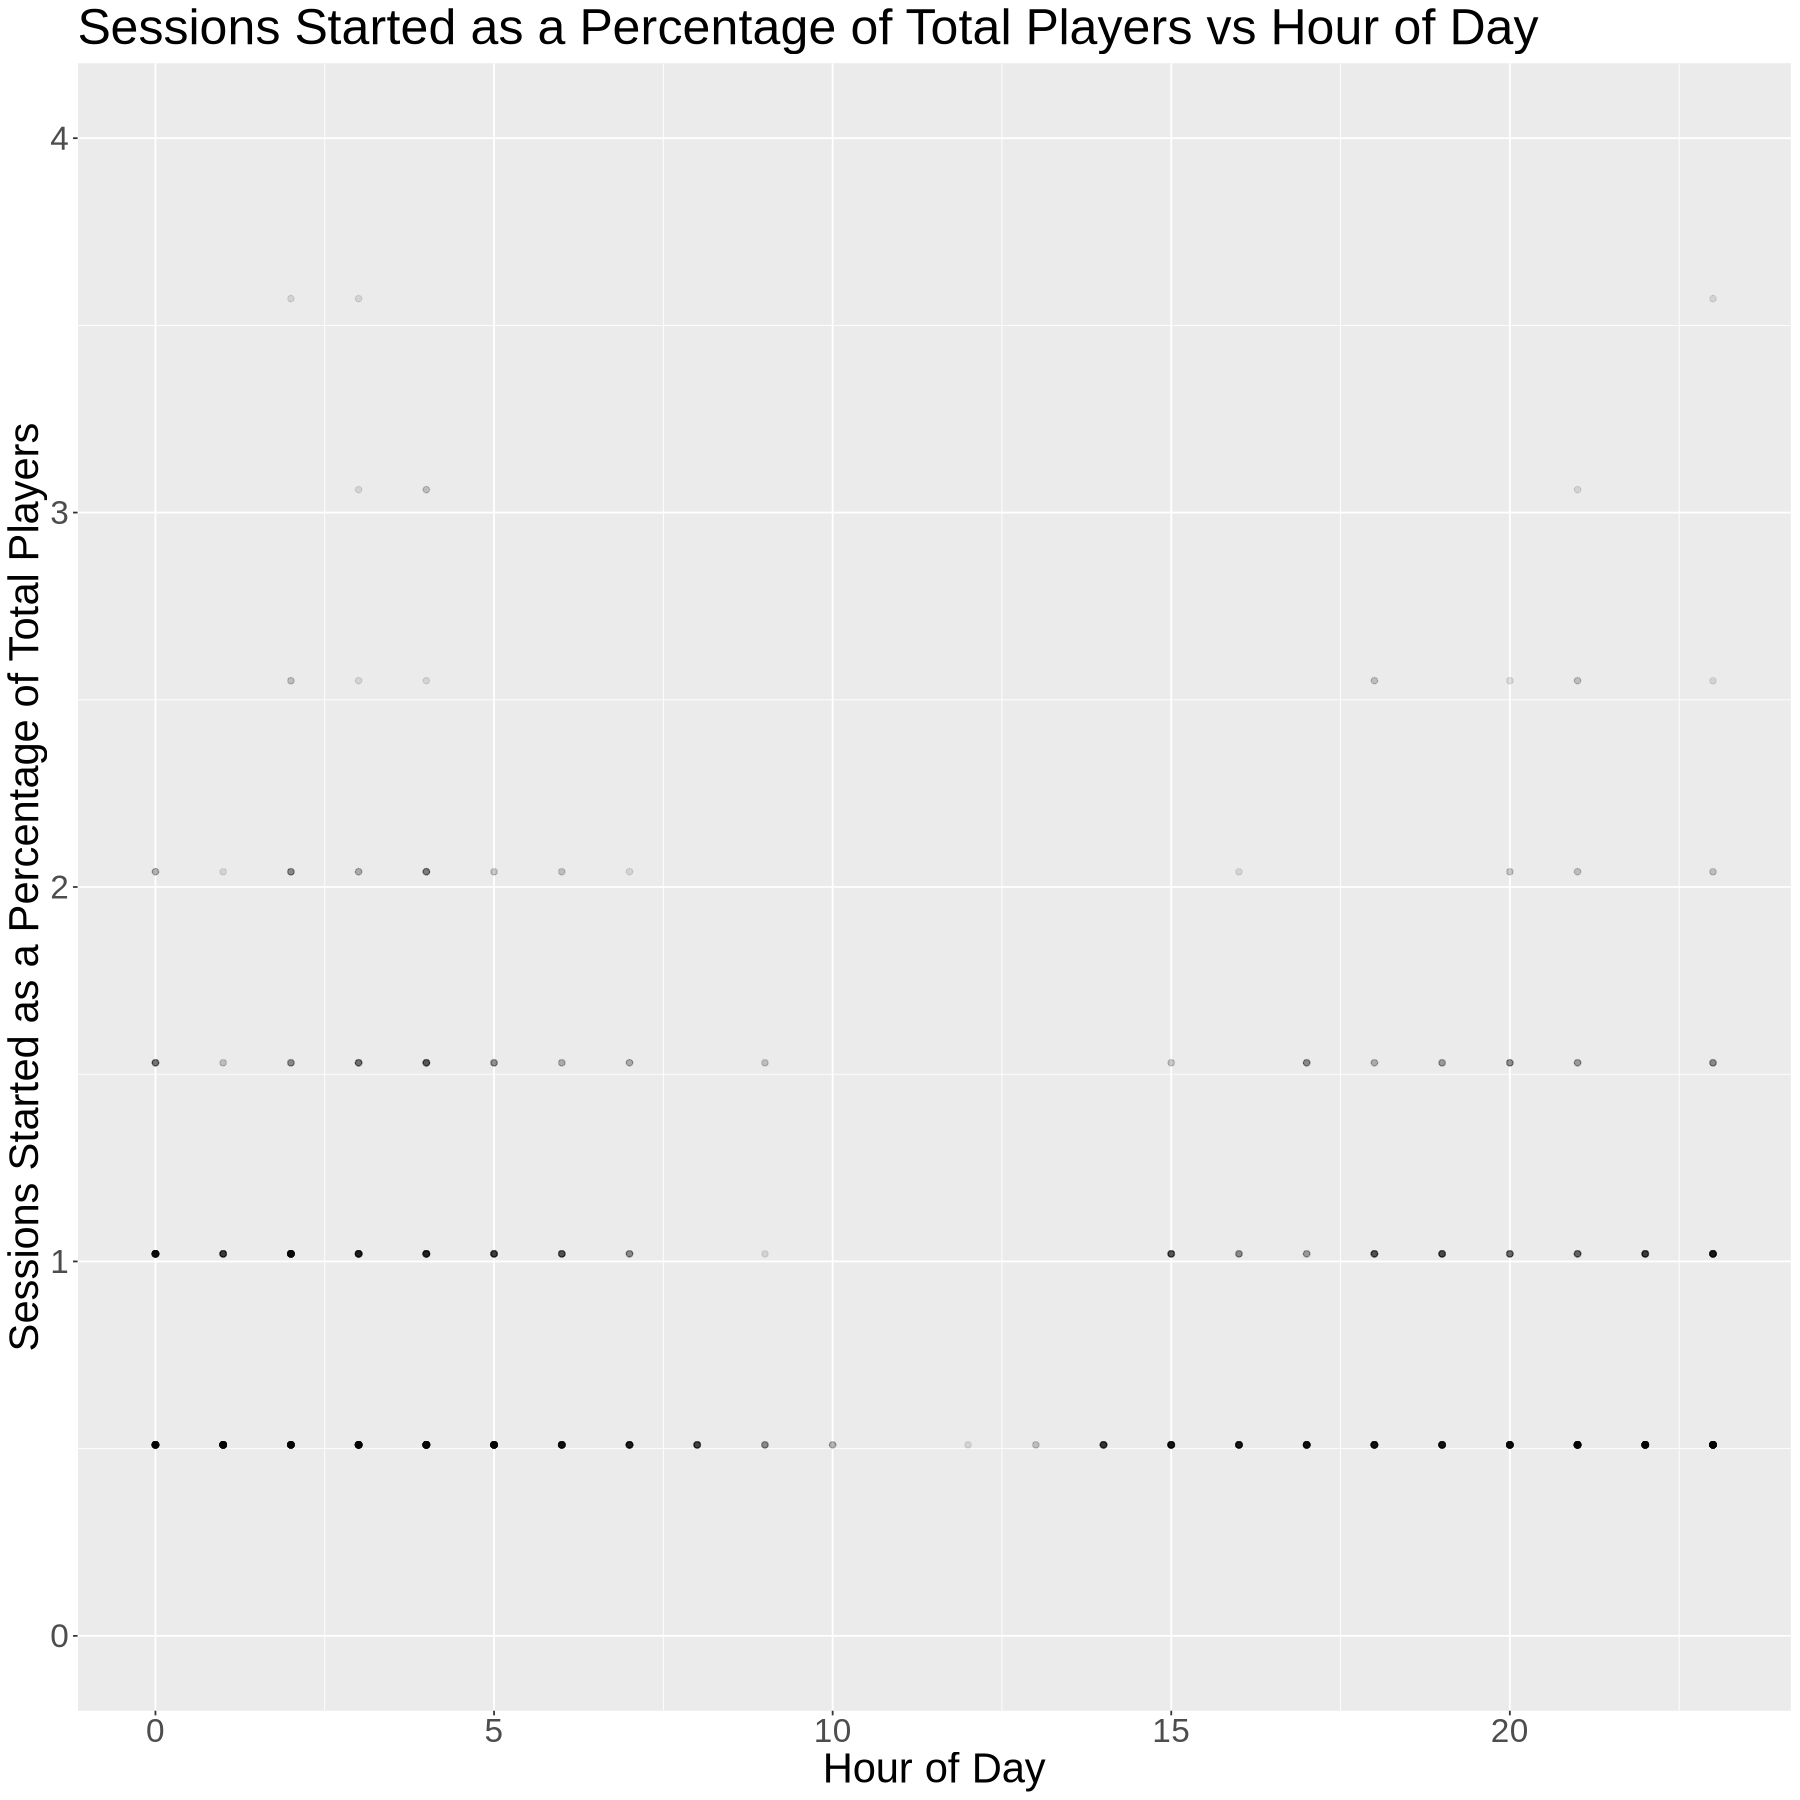

In [10]:
plot_sessions <- sessions_per_hour |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.1) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day") +
    ylim(c(0, 4)) +
    theme(text = element_text(size = 25))
plot_sessions

In [11]:
init_split <- initial_split(sessions_per_hour, prop = 0.7, strata = percentage_of_players)
sessions_train <- training(init_split)
sessions_test <- testing(init_split)

sessions_recipe <- recipe(percentage_of_players ~ start_hour, data = sessions_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
sessions_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 
sessions_vfold <- vfold_cv(sessions_train, v = 5, strata = percentage_of_players)
k_vals <- tibble(neighbors = seq(from = 1, to = 300, by = 3))
sessions_tune_results <- workflow() |>
    add_recipe(sessions_recipe) |>
    add_model(sessions_tune) |>
    tune_grid(resamples = sessions_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
sessions_tune_results

neighbors .metric .estimator mean      n std_err    .config               
1   1         rmse    standard   0.6220712 5 0.06670476 Preprocessor1_Model001
2   4         rmse    standard   0.6140837 5 0.06864499 Preprocessor1_Model002
3   7         rmse    standard   0.6045060 5 0.07142381 Preprocessor1_Model003
⋮   ⋮         ⋮       ⋮          ⋮         ⋮ ⋮          ⋮                     
98  292       rmse    standard   0.5916324 5 0.07789222 Preprocessor1_Model098
99  295       rmse    standard   0.5915250 5 0.07795648 Preprocessor1_Model099
100 298       rmse    standard   0.5915388 5 0.07810210 Preprocessor1_Model100

[1] 61

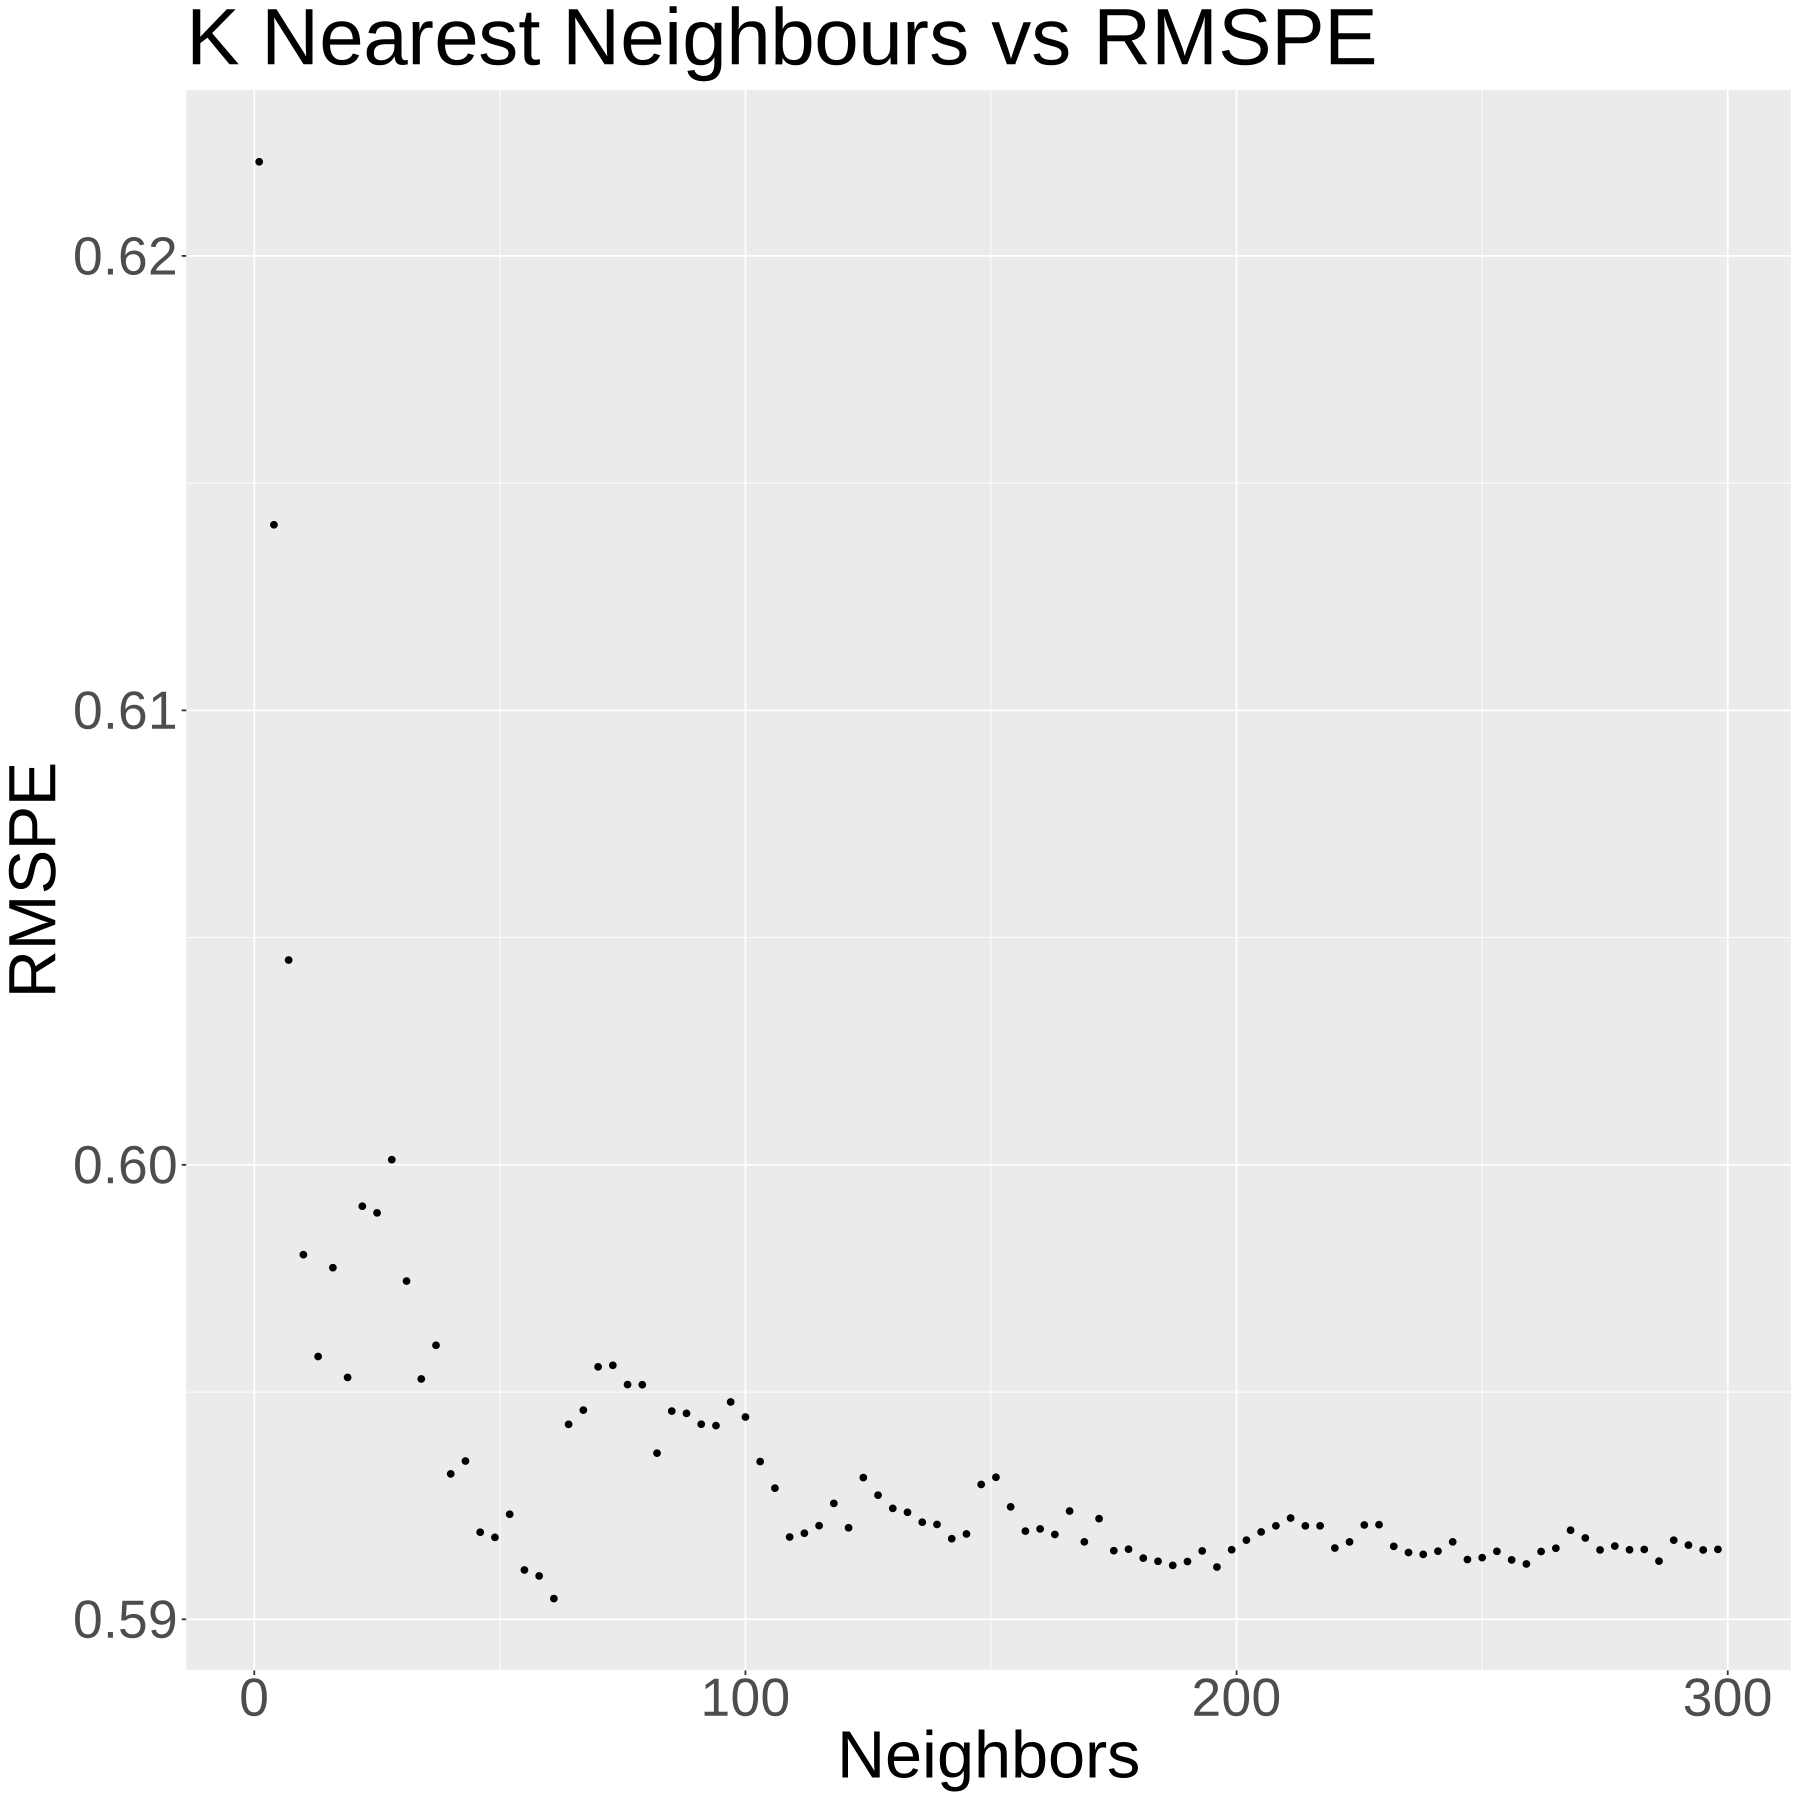

In [12]:
best_k_plot <- ggplot(sessions_tune_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Neighbors", y = "RMSPE", title = "K Nearest Neighbours vs RMSPE") +
    theme(text = element_text(size = 40))
best_k_plot
sessions_tune_best <- sessions_tune_results |>
    arrange(mean) |>
    select(neighbors) |>
    slice(1) |>
    pull()
sessions_tune_best

In [13]:
session_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = sessions_tune_best) |>
    set_engine("kknn") |>
    set_mode("regression")
session_fit <- workflow() |>
    add_recipe(sessions_recipe) |>
    add_model(session_spec) |>
    fit(data = sessions_train)
session_summary <- session_fit |>
  predict(sessions_test) |>
  bind_cols(sessions_test) |>
  metrics(truth = percentage_of_players, estimate = .pred) |>
  filter(.metric == 'rmse')
session_summary
sessions_test

.metric .estimator .estimate
1 rmse    standard   0.5684214

start_month start_day start_hour number_of_sessions percentage_of_players
1   5            5        22         9                  4.591837             
2   6            5         2         7                  3.571429             
3   6           29         3         6                  3.061224             
⋮   ⋮           ⋮         ⋮          ⋮                  ⋮                    
283 9           11        23         1                  0.5102041            
284 9           16         5         1                  0.5102041            
285 9           20         9         1                  0.5102041

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


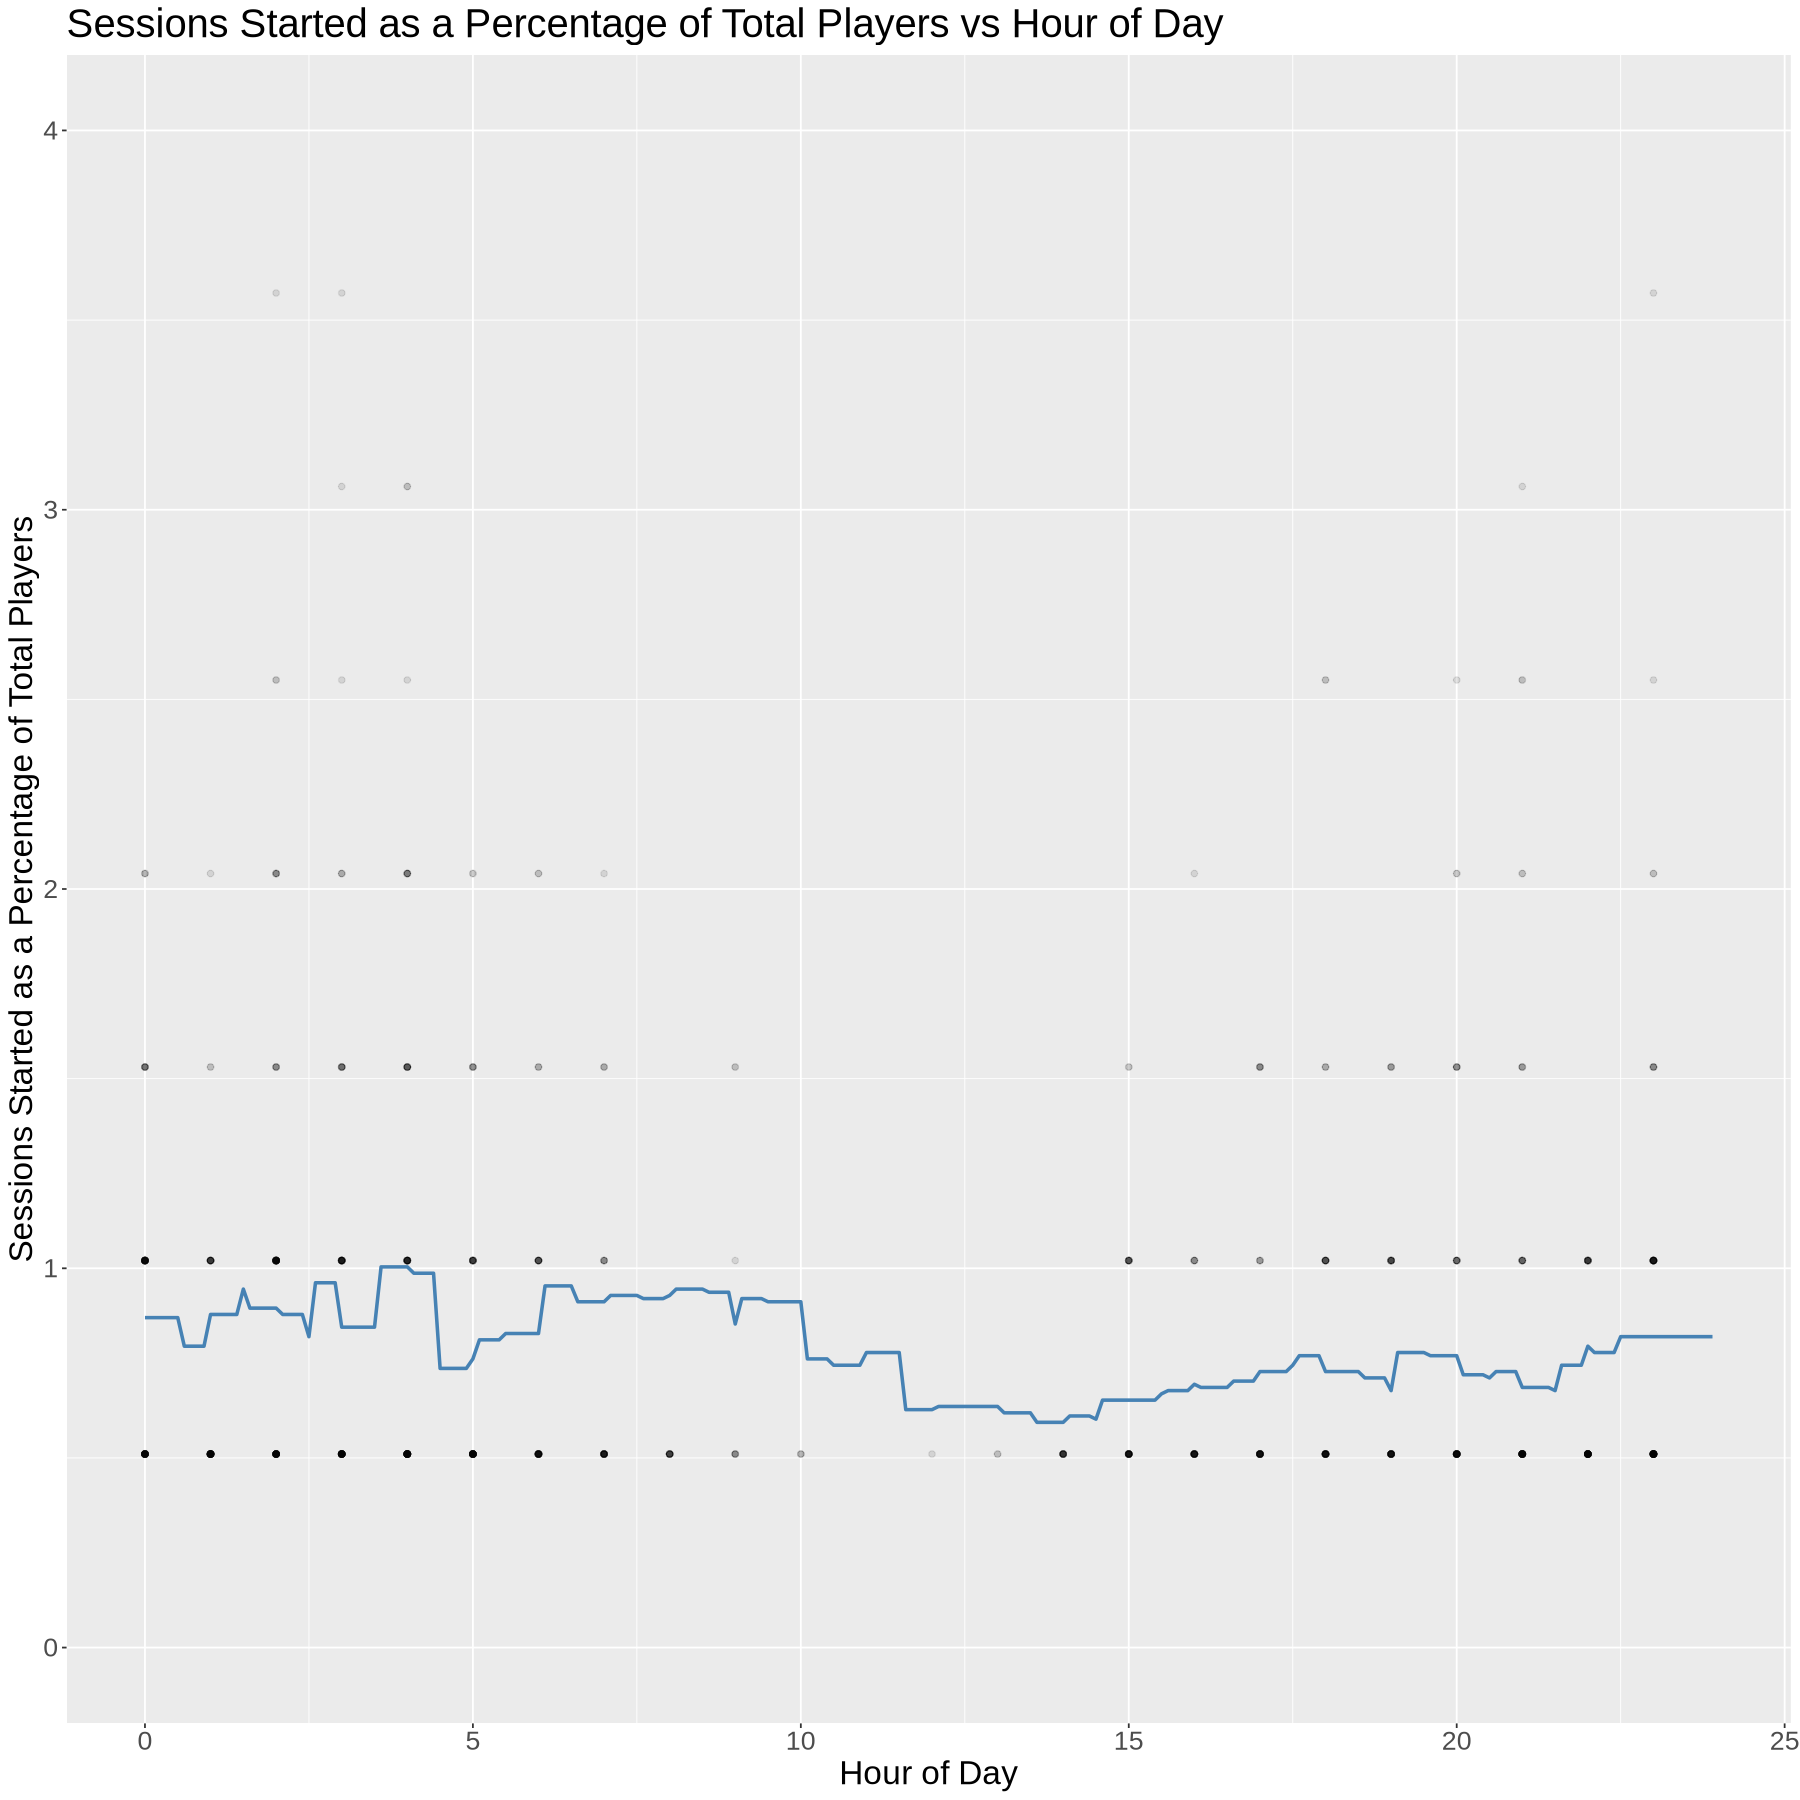

In [14]:
prediction_grid <- tibble(
    start_hour = seq(
        from = 0,
        to = 23.9,
        by = 0.1))

sessions_pred <- session_fit |>
    predict(prediction_grid) |>
    bind_cols(prediction_grid)

plot_sessions_final <- sessions_per_hour |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.1) +
    geom_line(data = sessions_pred,
            mapping = aes(x = start_hour, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day") +
    ylim(c(0, 4)) +
    theme(text = element_text(size = 20))
plot_sessions_final

#### Predicting by Month

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


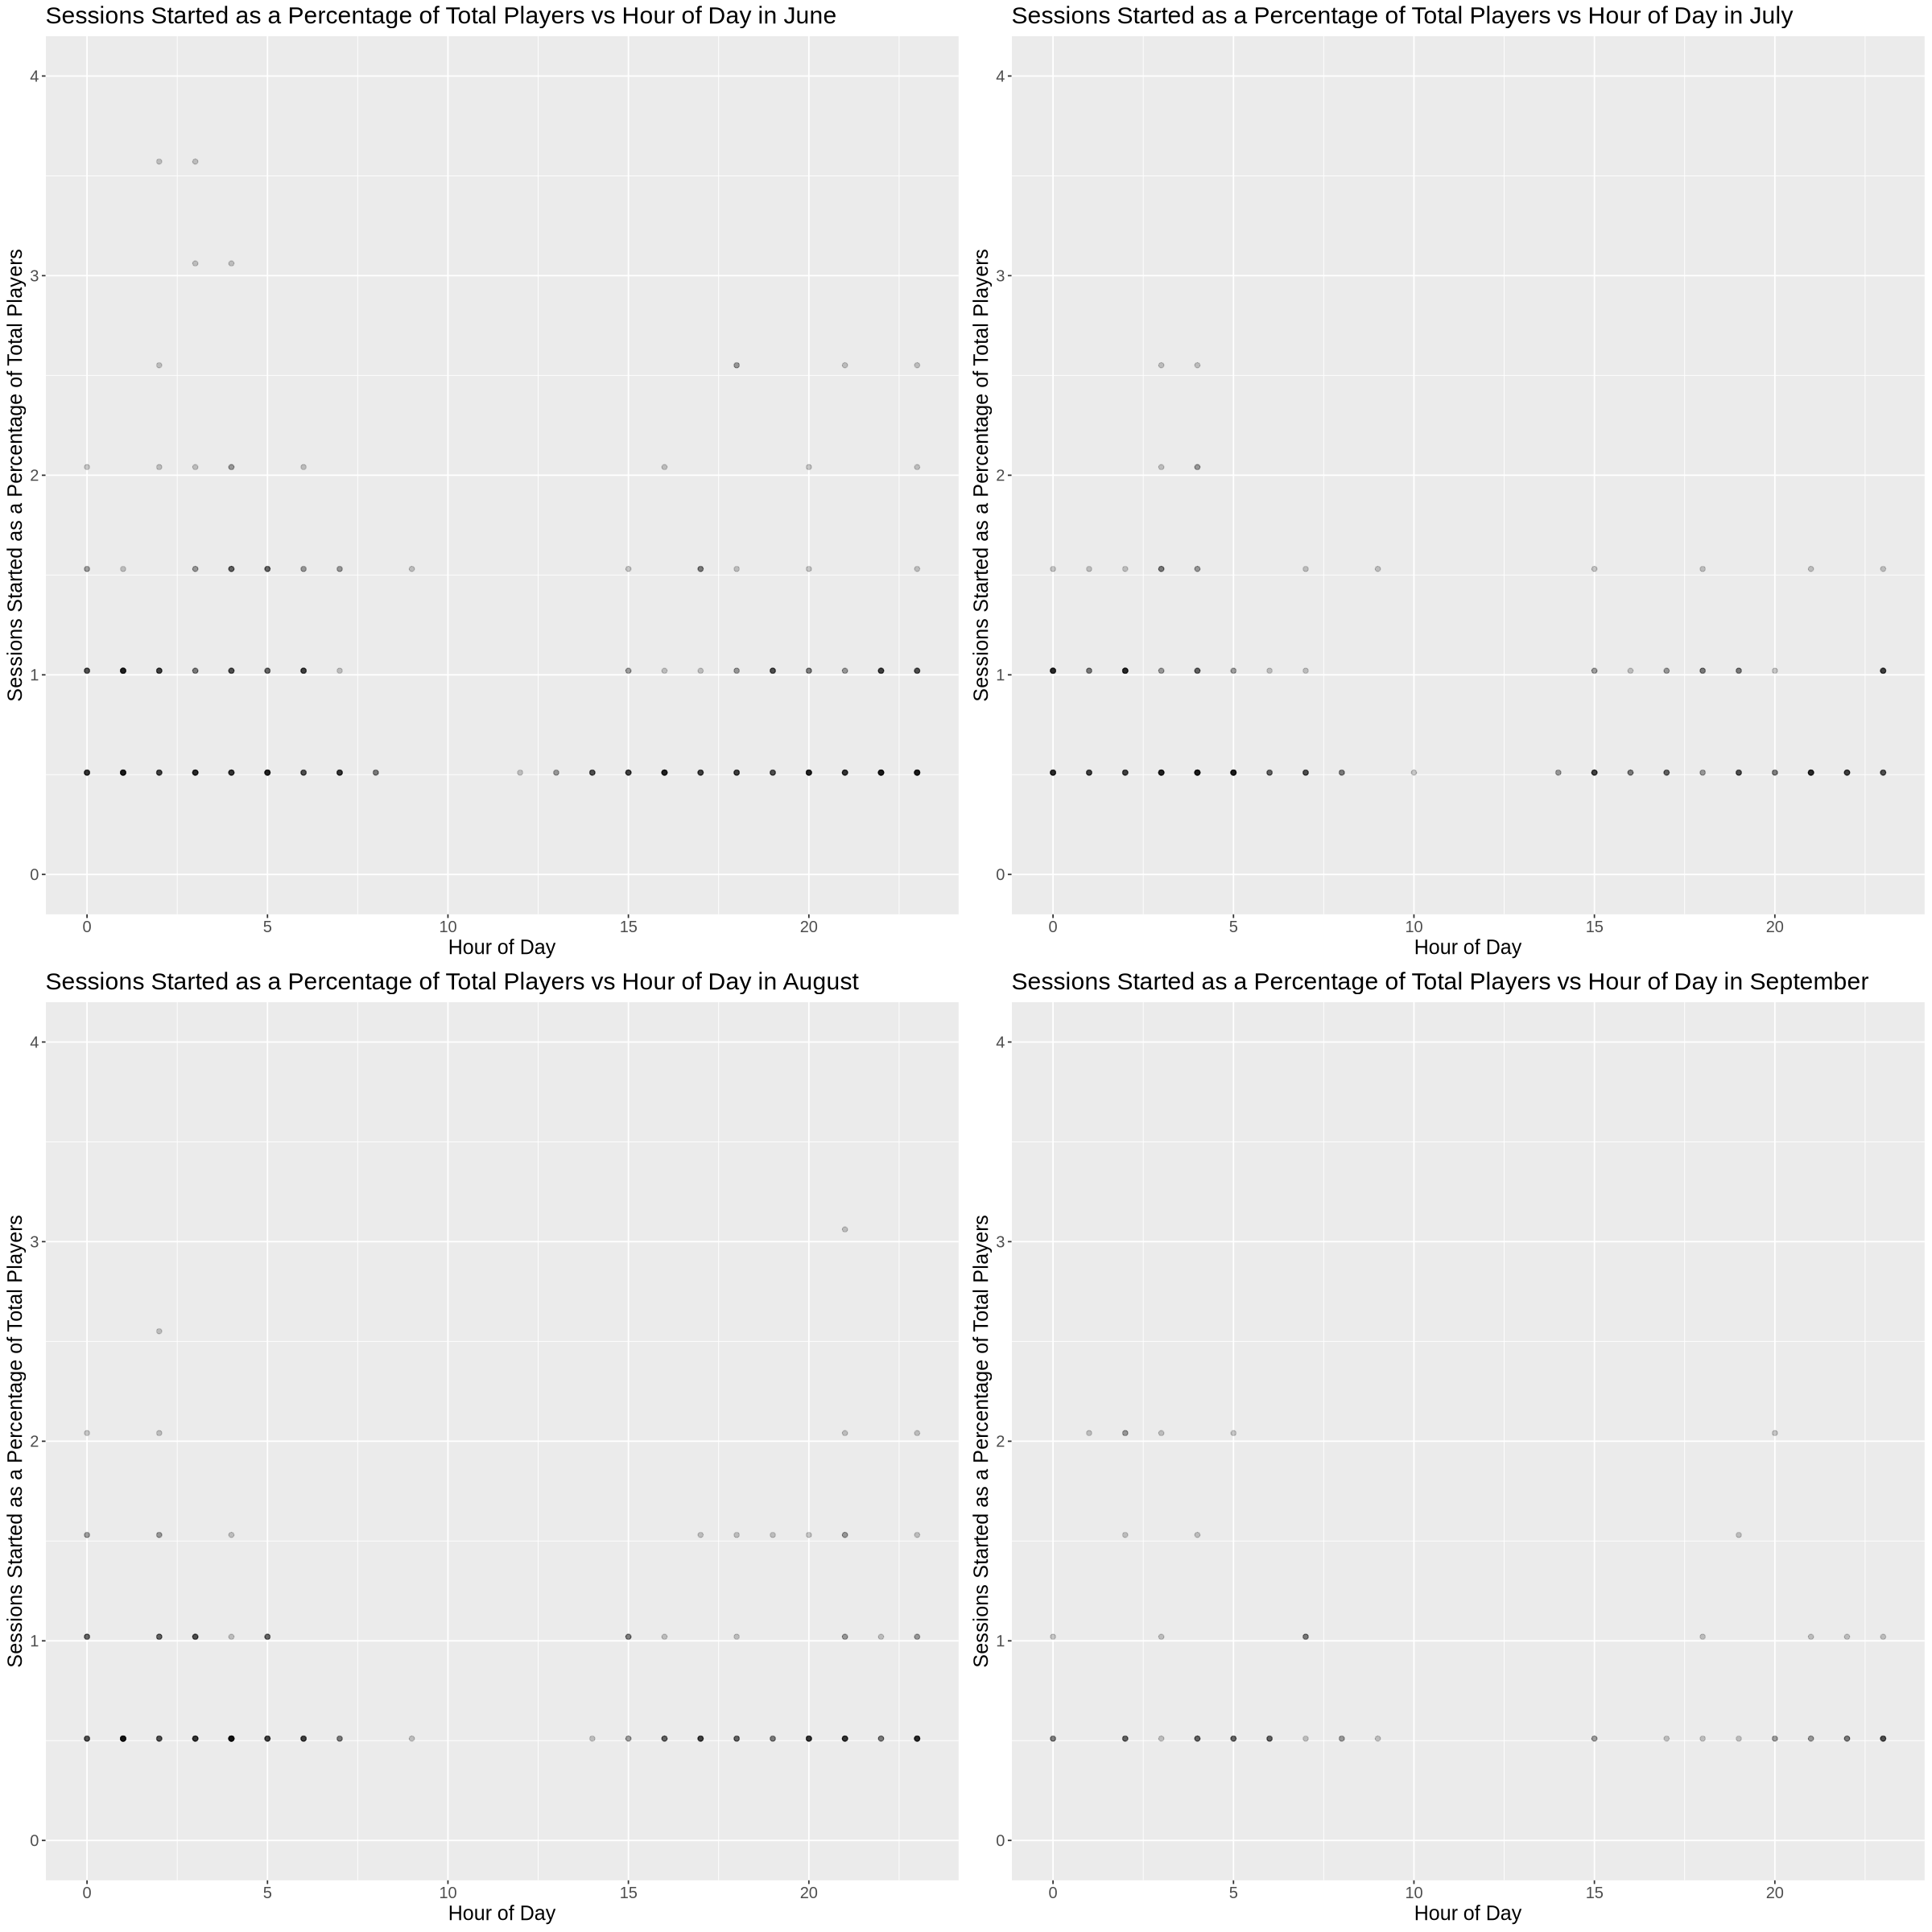

In [15]:
sessions_per_hour_june <- filter(sessions_per_hour, start_month == 6)
sessions_per_hour_july <- filter(sessions_per_hour, start_month == 7)
sessions_per_hour_august <- filter(sessions_per_hour, start_month == 8)
sessions_per_hour_september <- filter(sessions_per_hour, start_month == 9)
plot_sessions_june <- sessions_per_hour_june |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.2) +
    ylim(c(0, 4)) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in June") +
    theme(text = element_text(size = 15))
plot_sessions_july <- sessions_per_hour_july |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.2) +
    ylim(c(0, 4)) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in July") +
    theme(text = element_text(size = 15))
plot_sessions_august <- sessions_per_hour_august |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.2) +
    ylim(c(0, 4)) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in August") +
    theme(text = element_text(size = 15))
plot_sessions_september <- sessions_per_hour_september |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.2) +
    ylim(c(0, 4)) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in September") +
    theme(text = element_text(size = 15))
options(repr.plot.width = 20, repr.plot.height = 20)
plot_grid(plot_sessions_june,
          plot_sessions_july,
          plot_sessions_august,
          plot_sessions_september,
          ncol=2)
          

In [16]:
#June
init_split_june <- initial_split(sessions_per_hour_june, prop = 0.7, strata = percentage_of_players)
sessions_train_june <- training(init_split_june)
sessions_test_june <- testing(init_split_june)
sessions_recipe_june <- recipe(percentage_of_players ~ start_hour, data = sessions_train_june) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
sessions_vfold_june <- vfold_cv(sessions_train_june, v = 5, strata = percentage_of_players)
k_vals_month <- tibble(neighbors = seq(from = 1, to = 25, by = 1))
sessions_tune_results_june <- workflow() |>
    add_recipe(sessions_recipe_june) |>
    add_model(sessions_tune) |>
    tune_grid(resamples = sessions_vfold_june, grid = k_vals_month) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
#July
init_split_july <- initial_split(sessions_per_hour_july, prop = 0.7, strata = percentage_of_players)
sessions_train_july <- training(init_split_july)
sessions_test_july <- testing(init_split_july)
sessions_recipe_july <- recipe(percentage_of_players ~ start_hour, data = sessions_train_july) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
sessions_vfold_july <- vfold_cv(sessions_train_july, v = 5, strata = percentage_of_players)
sessions_tune_results_july <- workflow() |>
    add_recipe(sessions_recipe_july) |>
    add_model(sessions_tune) |>
    tune_grid(resamples = sessions_vfold_july, grid = k_vals_month) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
#August
init_split_august <- initial_split(sessions_per_hour_august, prop = 0.7, strata = percentage_of_players)
sessions_train_august <- training(init_split_august)
sessions_test_august <- testing(init_split_august)
sessions_recipe_august <- recipe(percentage_of_players ~ start_hour, data = sessions_train_august) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
sessions_vfold_august <- vfold_cv(sessions_train_august, v = 5, strata = percentage_of_players)
sessions_tune_results_august <- workflow() |>
    add_recipe(sessions_recipe_august) |>
    add_model(sessions_tune) |>
    tune_grid(resamples = sessions_vfold_august, grid = k_vals_month) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
#September
init_split_september <- initial_split(sessions_per_hour_september, prop = 0.7, strata = percentage_of_players)
sessions_train_september <- training(init_split_september)
sessions_test_september <- testing(init_split_september)
sessions_recipe_september <- recipe(percentage_of_players ~ start_hour, data = sessions_train_september) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
sessions_vfold_september <- vfold_cv(sessions_train_september, v = 5, strata = percentage_of_players)
sessions_tune_results_september <- workflow() |>
    add_recipe(sessions_recipe_september) |>
    add_model(sessions_tune) |>
    tune_grid(resamples = sessions_vfold_september, grid = k_vals_month) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
#Best K values for each month
sessions_tune_best_june <- sessions_tune_results_june |>
    arrange(mean) |>
    select(neighbors) |>
    slice(1) |>
    pull()
sessions_tune_best_june

sessions_tune_best_july <- sessions_tune_results_july |>
    arrange(mean) |>
    select(neighbors) |>
    slice(1) |>
    pull()
sessions_tune_best_july

sessions_tune_best_august <- sessions_tune_results_august |>
    arrange(mean) |>
    select(neighbors) |>
    slice(1) |>
    pull()
sessions_tune_best_august

sessions_tune_best_september <- sessions_tune_results_september |>
    arrange(mean) |>
    select(neighbors) |>
    slice(1) |>
    pull()
sessions_tune_best_september

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x2





[1] 25

[1] 25

[1] 24

[1] 24

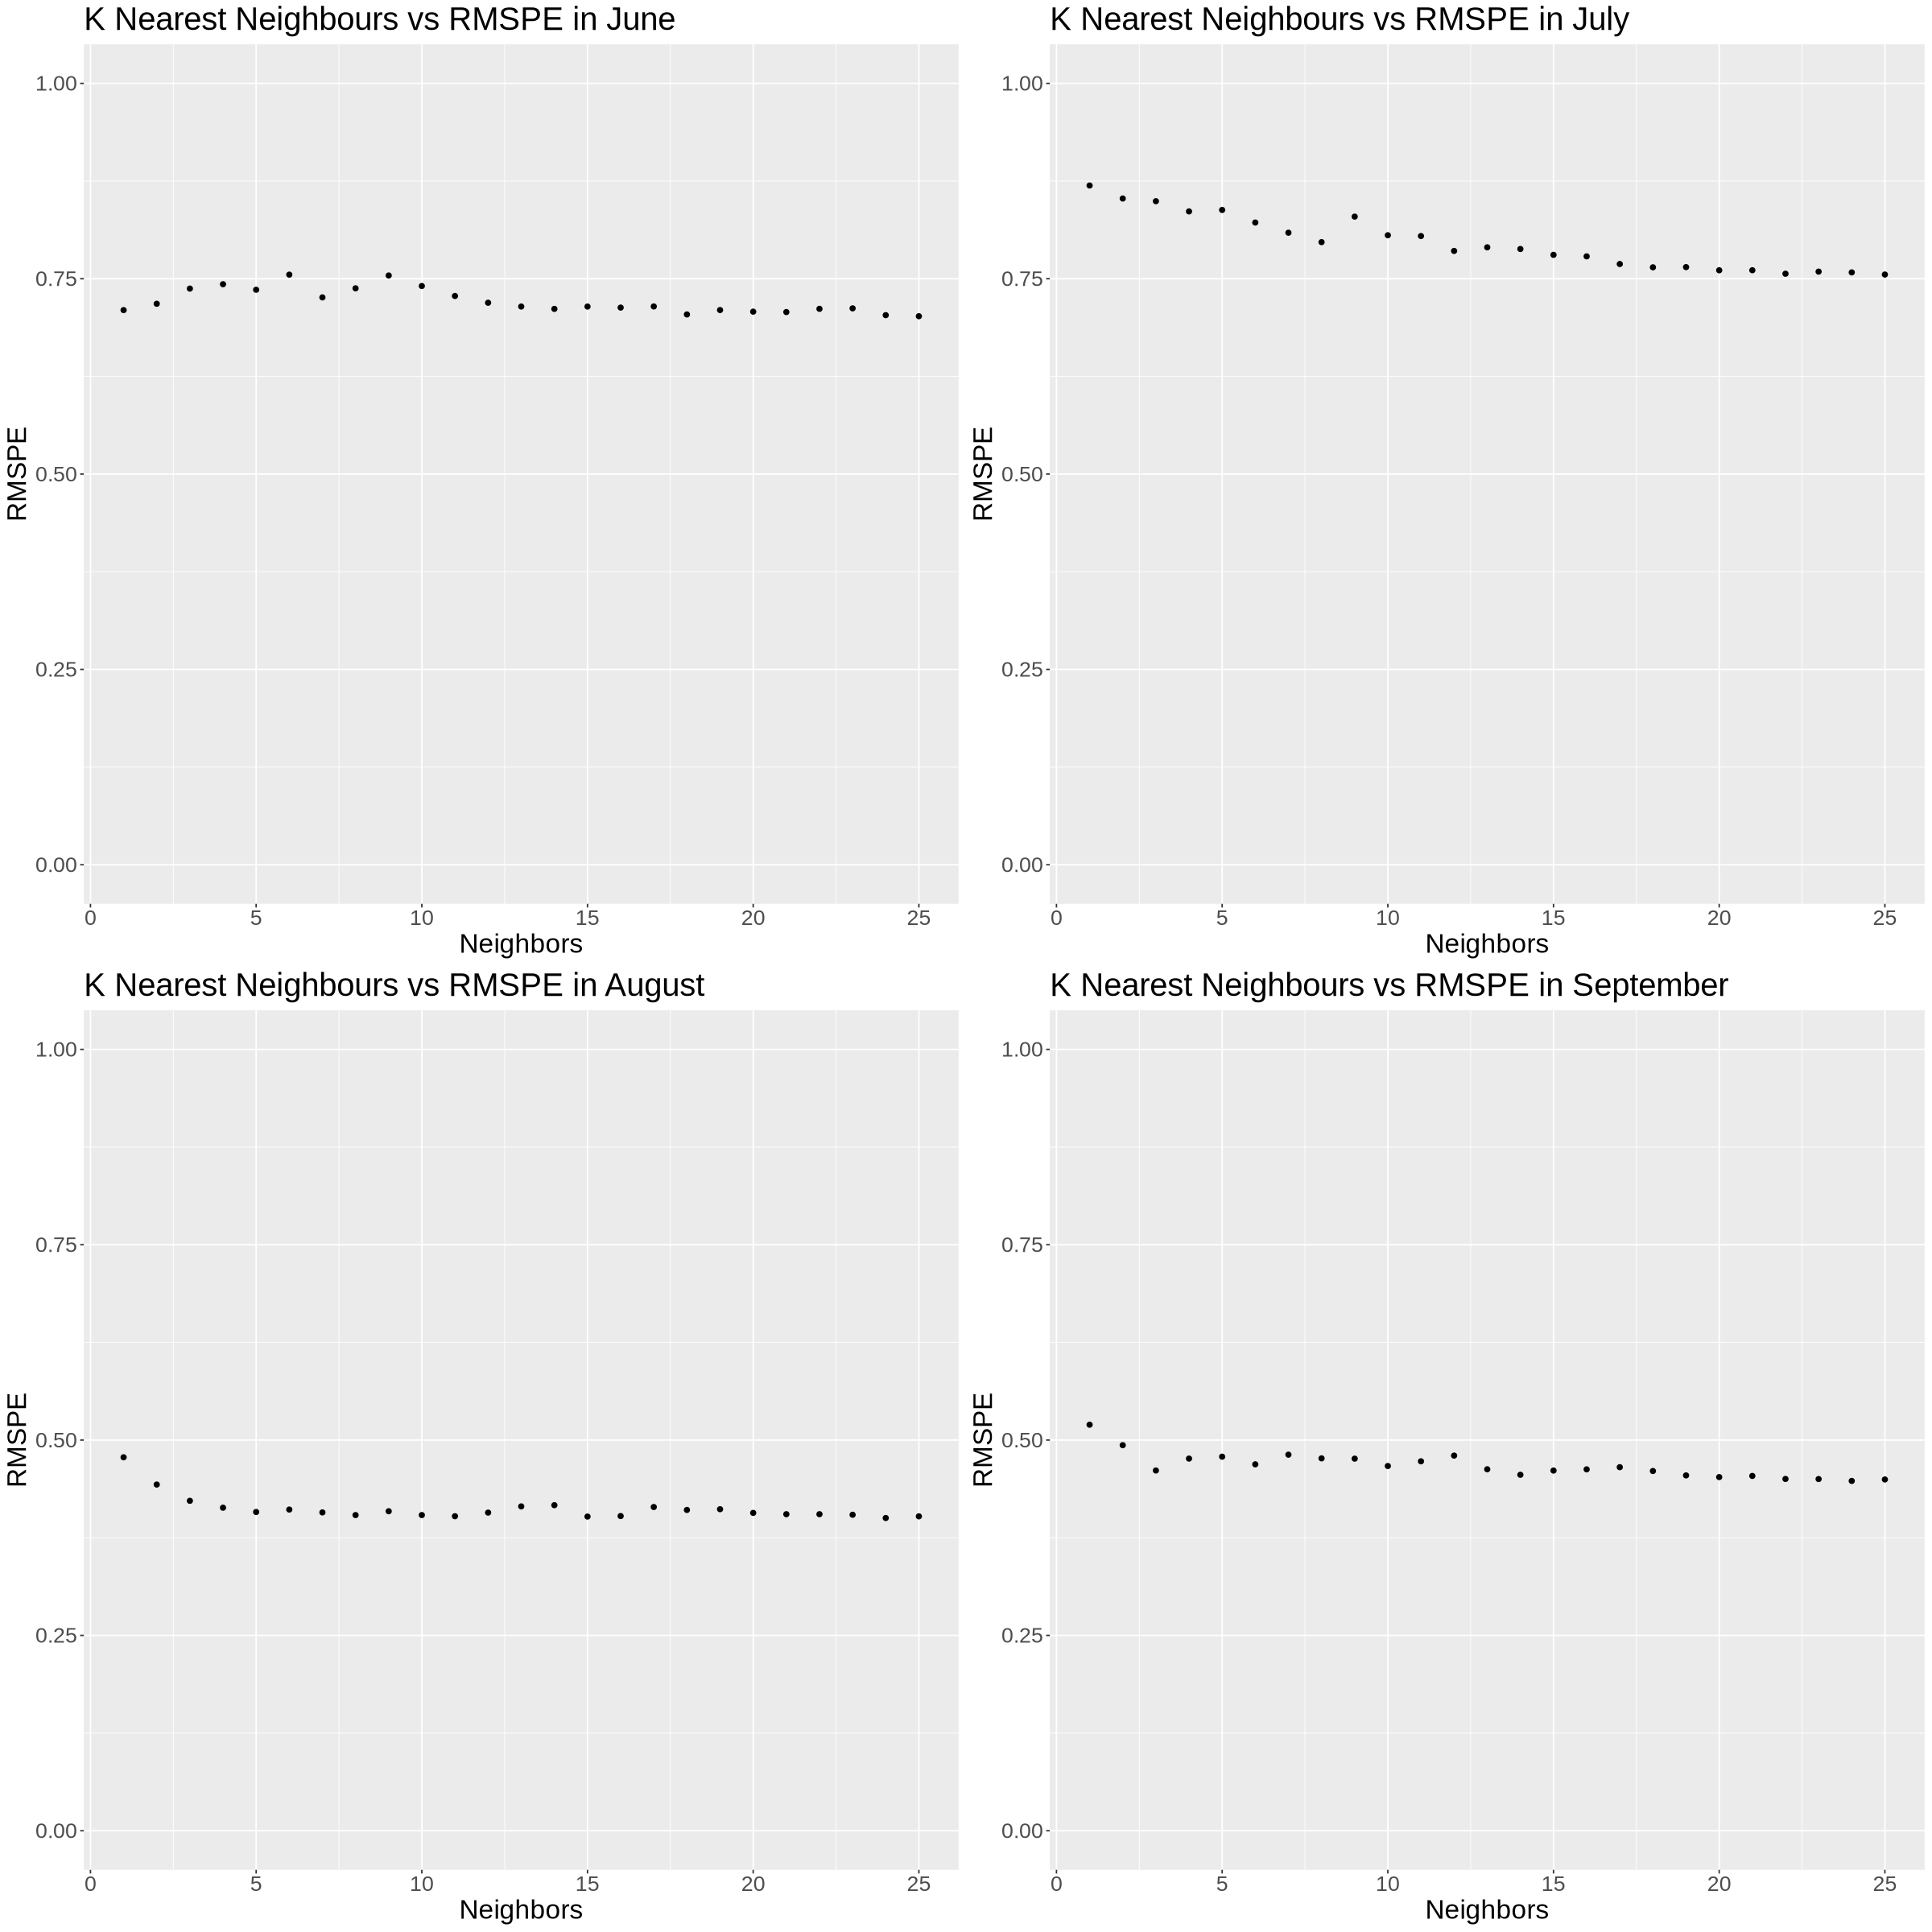

In [17]:
best_k_plot_june <- ggplot(sessions_tune_results_june, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Neighbors", y = "RMSPE", title = "K Nearest Neighbours vs RMSPE in June") +
    ylim(c(0, 1)) +
    theme(text = element_text(size = 20))

best_k_plot_july <- ggplot(sessions_tune_results_july, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Neighbors", y = "RMSPE", title = "K Nearest Neighbours vs RMSPE in July") +
    ylim(c(0, 1)) +
    theme(text = element_text(size = 20))

best_k_plot_august <- ggplot(sessions_tune_results_august, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Neighbors", y = "RMSPE", title = "K Nearest Neighbours vs RMSPE in August") +
    ylim(c(0, 1)) +
    theme(text = element_text(size = 20))

best_k_plot_september <- ggplot(sessions_tune_results_september, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Neighbors", y = "RMSPE", title = "K Nearest Neighbours vs RMSPE in September") +
    ylim(c(0, 1)) +
    theme(text = element_text(size = 20))

plot_grid(best_k_plot_june,
          best_k_plot_july,
          best_k_plot_august,
          best_k_plot_september,
          ncol=2)

In [18]:
#June
session_spec_june <- nearest_neighbor(weight_func = "rectangular", neighbors = sessions_tune_best_june) |>
    set_engine("kknn") |>
    set_mode("regression")
session_fit_june <- workflow() |>
    add_recipe(sessions_recipe_june) |>
    add_model(session_spec_june) |>
    fit(data = sessions_train_june)
session_summary_june <- session_fit_june |>
  predict(sessions_test_june) |>
  bind_cols(sessions_test_june) |>
  metrics(truth = percentage_of_players, estimate = .pred) |>
  filter(.metric == 'rmse')
session_summary_june
#July
session_spec_july <- nearest_neighbor(weight_func = "rectangular", neighbors = sessions_tune_best_july) |>
    set_engine("kknn") |>
    set_mode("regression")
session_fit_july <- workflow() |>
    add_recipe(sessions_recipe_july) |>
    add_model(session_spec_july) |>
    fit(data = sessions_train_july)
session_summary_july <- session_fit_july |>
  predict(sessions_test_july) |>
  bind_cols(sessions_test_july) |>
  metrics(truth = percentage_of_players, estimate = .pred) |>
  filter(.metric == 'rmse')
session_summary_july
#August
session_spec_august <- nearest_neighbor(weight_func = "rectangular", neighbors = sessions_tune_best_august) |>
    set_engine("kknn") |>
    set_mode("regression")
session_fit_august <- workflow() |>
    add_recipe(sessions_recipe_august) |>
    add_model(session_spec_august) |>
    fit(data = sessions_train_august)
session_summary_august <- session_fit_august |>
  predict(sessions_test_august) |>
  bind_cols(sessions_test_august) |>
  metrics(truth = percentage_of_players, estimate = .pred) |>
  filter(.metric == 'rmse')
session_summary_august
#September
session_spec_september <- nearest_neighbor(weight_func = "rectangular", neighbors = sessions_tune_best_september) |>
    set_engine("kknn") |>
    set_mode("regression")
session_fit_september <- workflow() |>
    add_recipe(sessions_recipe_september) |>
    add_model(session_spec_september) |>
    fit(data = sessions_train_september)
session_summary_september <- session_fit_september |>
  predict(sessions_test_september) |>
  bind_cols(sessions_test_september) |>
  metrics(truth = percentage_of_players, estimate = .pred) |>
  filter(.metric == 'rmse')
session_summary_september

.metric .estimator .estimate
1 rmse    standard   0.6310529

.metric .estimator .estimate
1 rmse    standard   0.3853665

.metric .estimator .estimate
1 rmse    standard   0.5525848

.metric .estimator .estimate
1 rmse    standard   0.5677254

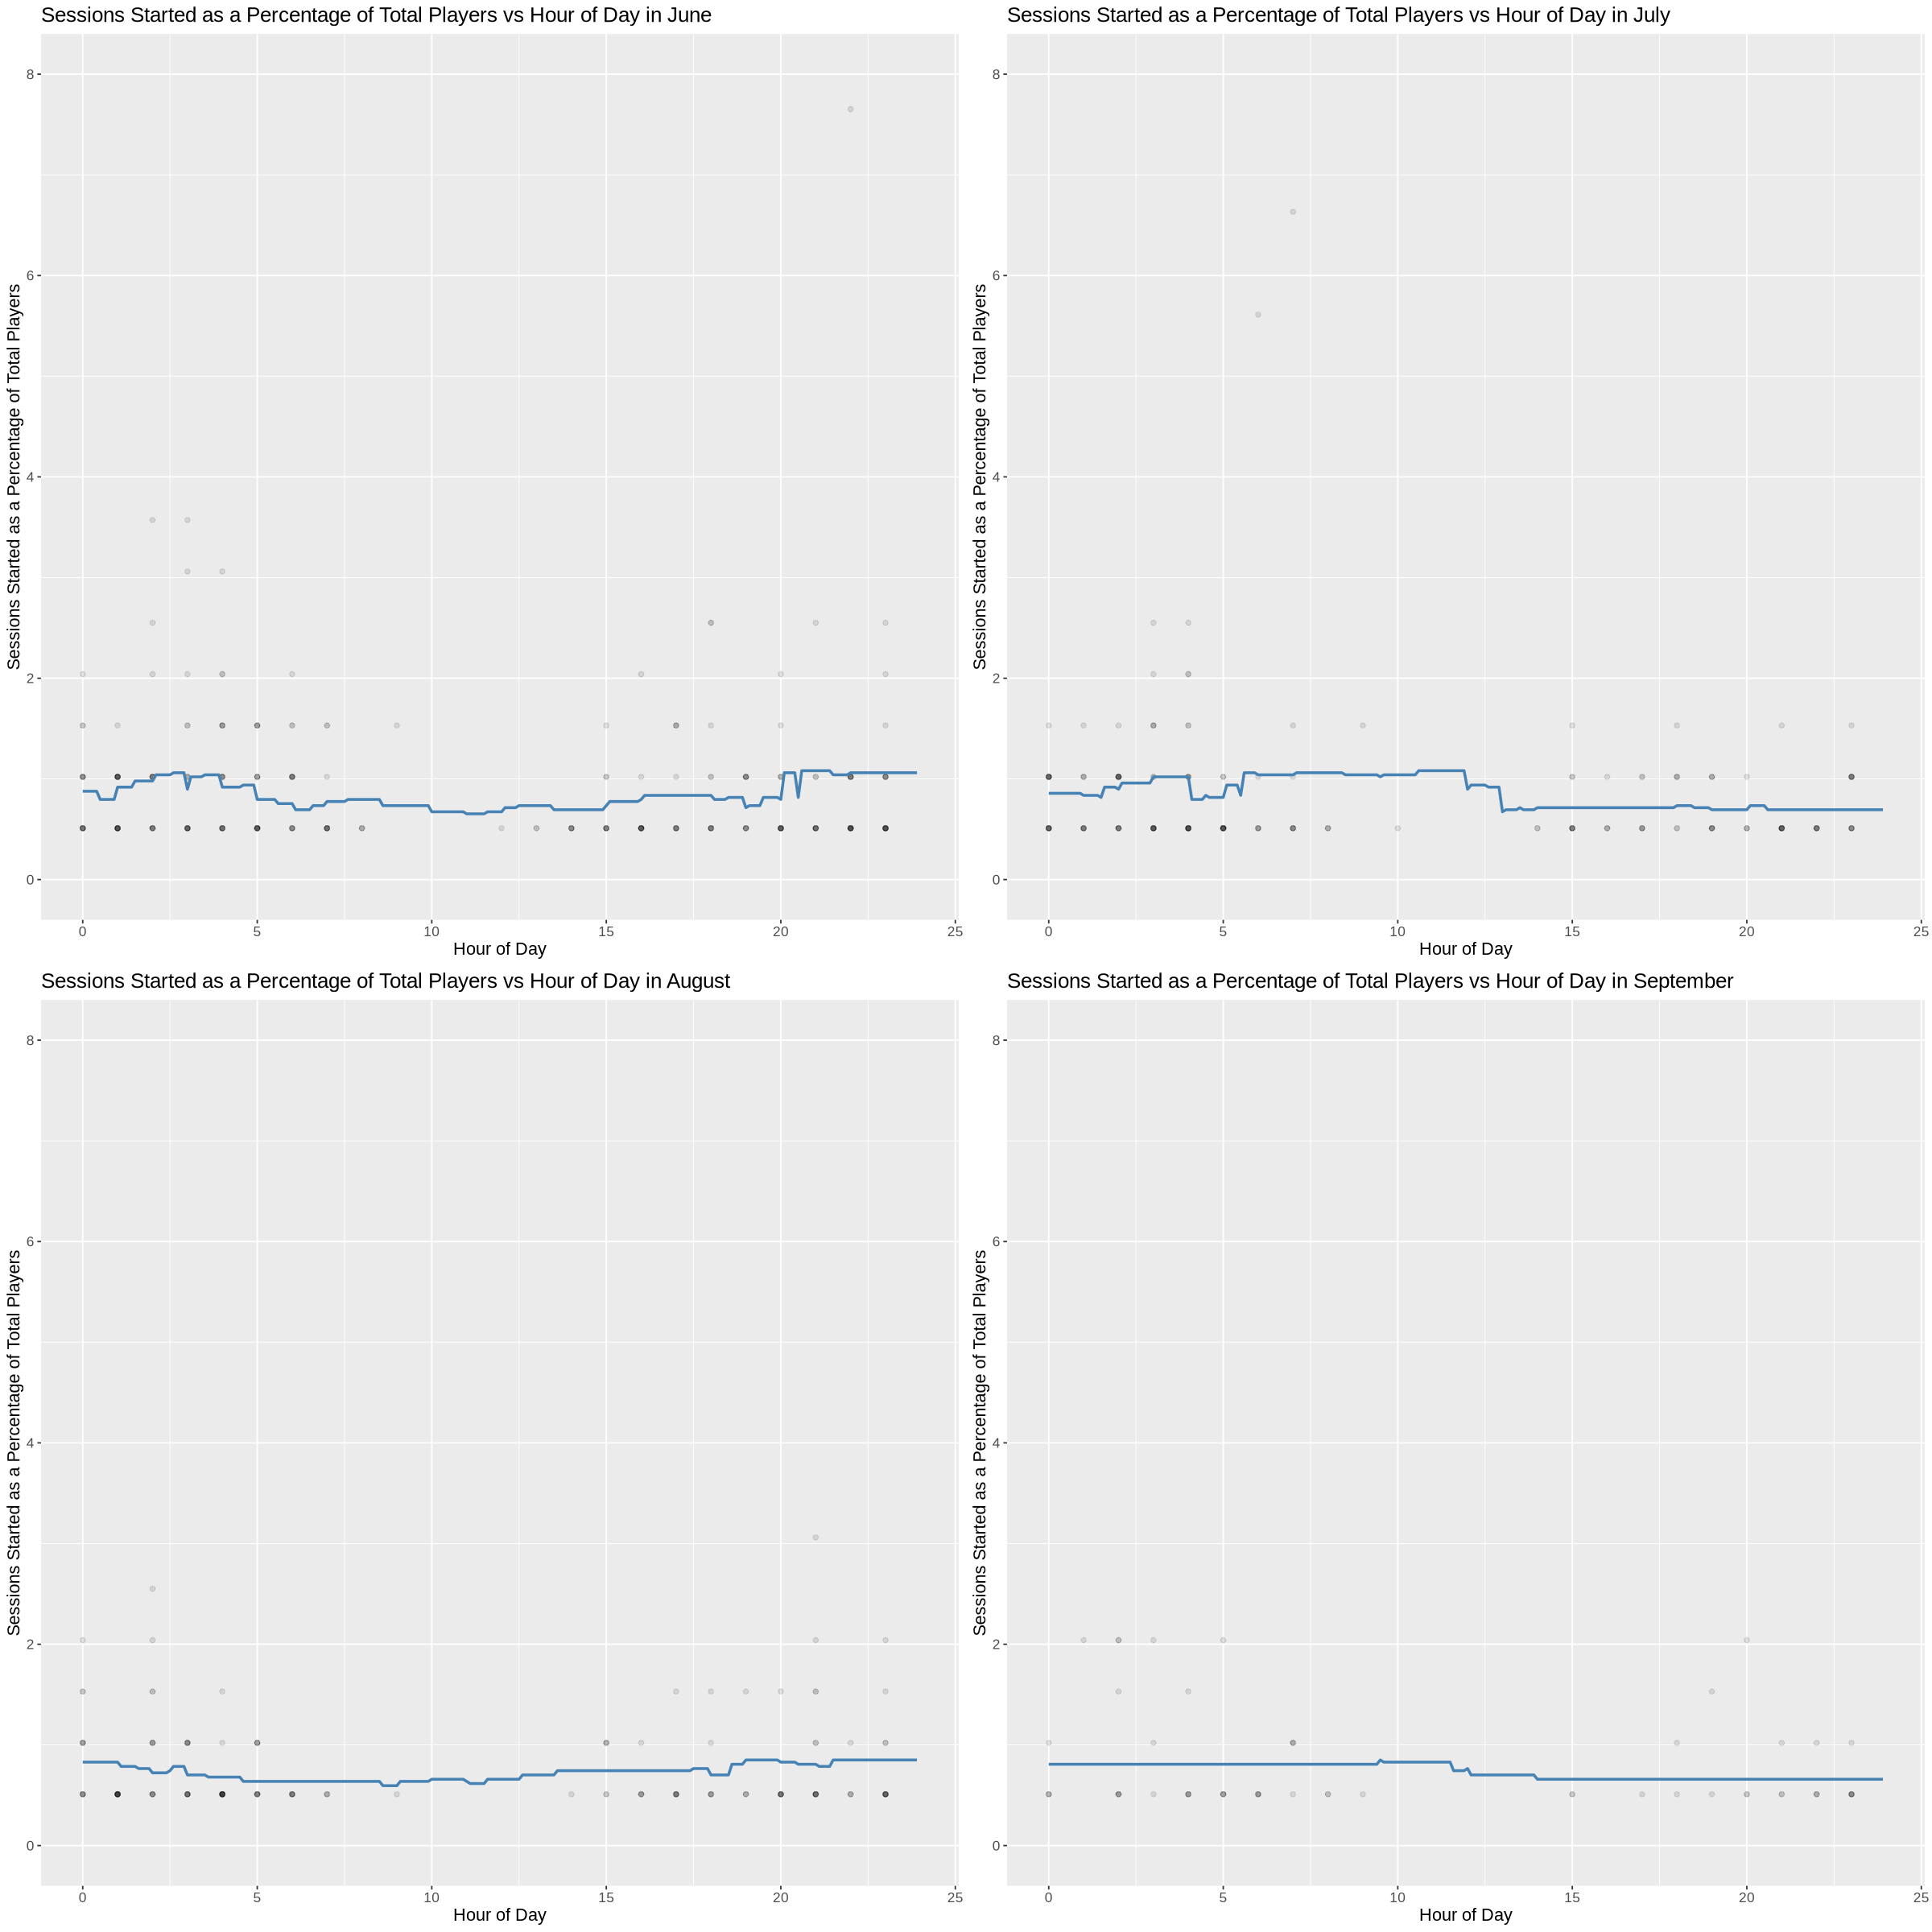

In [19]:
prediction_grid <- tibble(
    start_hour = seq(
        from = 0,
        to = 23.9,
        by = 0.1))
#June
sessions_pred_june <- session_fit_june |>
    predict(prediction_grid) |>
    bind_cols(prediction_grid)

plot_sessions_final_june <- sessions_per_hour_june |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.1) +
    geom_line(data = sessions_pred_june,
            mapping = aes(x = start_hour, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in June") +
    ylim(c(0, 8)) +
    theme(text = element_text(size = 13))

#July
sessions_pred_july <- session_fit_july |>
    predict(prediction_grid) |>
    bind_cols(prediction_grid)

plot_sessions_final_july <- sessions_per_hour_july |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.1) +
    geom_line(data = sessions_pred_july,
            mapping = aes(x = start_hour, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in July") +
    ylim(c(0, 8)) +
    theme(text = element_text(size = 13))

#August
sessions_pred_august <- session_fit_august |>
    predict(prediction_grid) |>
    bind_cols(prediction_grid)

plot_sessions_final_august <- sessions_per_hour_august |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.1) +
    geom_line(data = sessions_pred_august,
            mapping = aes(x = start_hour, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in August") +
    ylim(c(0, 8)) +
    theme(text = element_text(size = 13))

#September
sessions_pred_september <- session_fit_september |>
    predict(prediction_grid) |>
    bind_cols(prediction_grid)

plot_sessions_final_september <- sessions_per_hour_september |>
    ggplot(aes(x = start_hour, y = percentage_of_players)) +
    geom_point(alpha = 0.1) +
    geom_line(data = sessions_pred_september,
            mapping = aes(x = start_hour, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    labs(x = "Hour of Day", y = "Sessions Started as a Percentage of Total Players", 
         title = "Sessions Started as a Percentage of Total Players vs Hour of Day in September") +
    ylim(c(0, 8)) +
    theme(text = element_text(size = 13))
plot_grid(plot_sessions_final_june,
          plot_sessions_final_july,
          plot_sessions_final_august,
          plot_sessions_final_september,
          ncol=2)
